Found 805 pairs
Sample shapes -> RGB: (1024, 1024, 3) Mask: (1024, 1024, 3) dtype: uint8
Total pixels: 844,103,680

Regions
  0 | Exclude                      :   68,924,245  (  8.17%)
  1 | Cancerous epithelium         :  290,170,877  ( 34.38%)
  2 | Stroma                       :  244,570,125  ( 28.97%)
  3 | TILs                         :   84,811,139  ( 10.05%)
  4 | Normal epithelium            :      639,385  (  0.08%)
  5 | Junk/Debris                  :   35,973,718  (  4.26%)
  6 | Blood                        :    1,879,416  (  0.22%)
  7 | Other                        :    4,046,333  (  0.48%)
  8 | Whitespace/Empty             :  113,088,442  ( 13.40%)

Nuclei
  0 | Exclude                      :   69,592,268  (  8.24%)
  1 | Cancer nucleus               :  116,214,631  ( 13.77%)
  2 | Stromal nucleus              :   41,937,488  (  4.97%)
  3 | Large stromal nucleus        :   10,429,481  (  1.24%)
  4 | Lymphocyte nucleus           :   23,513,642  (  2.79%)
  5 | Plasma/l

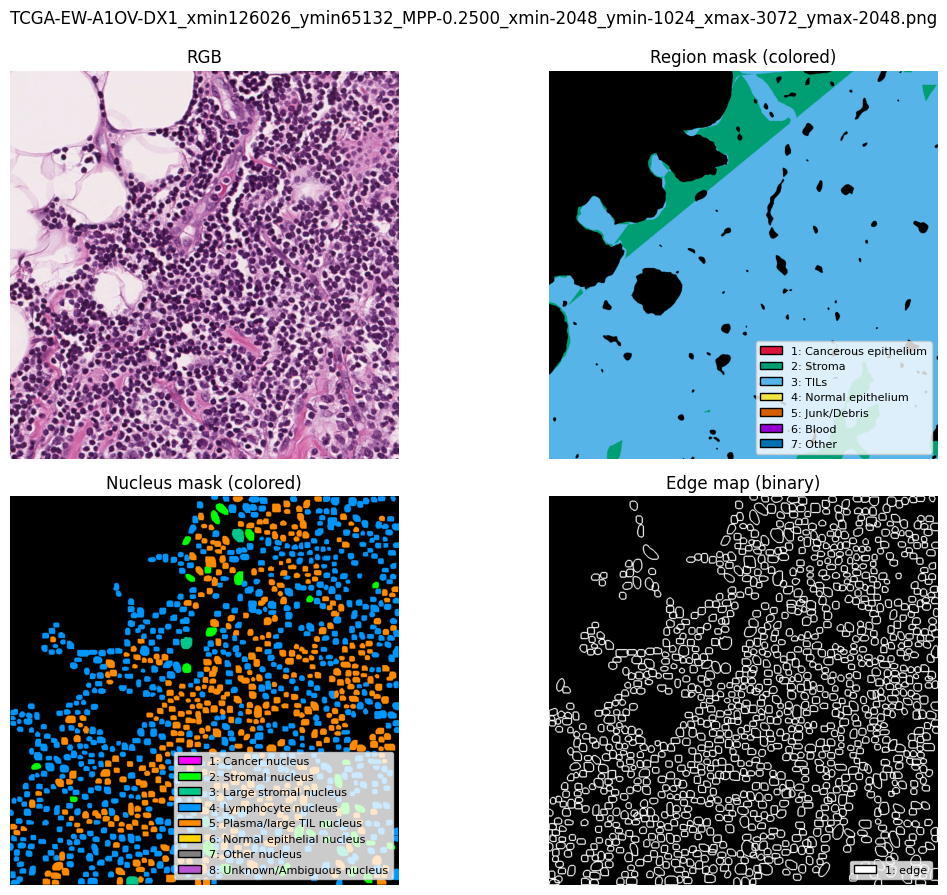

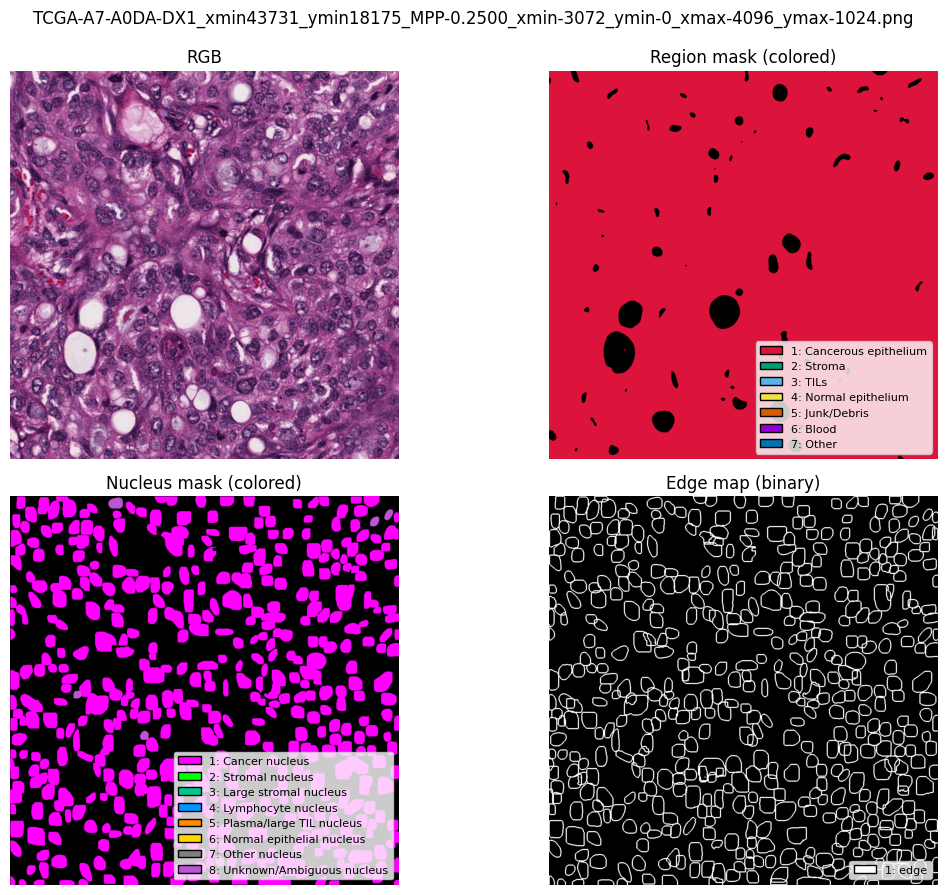

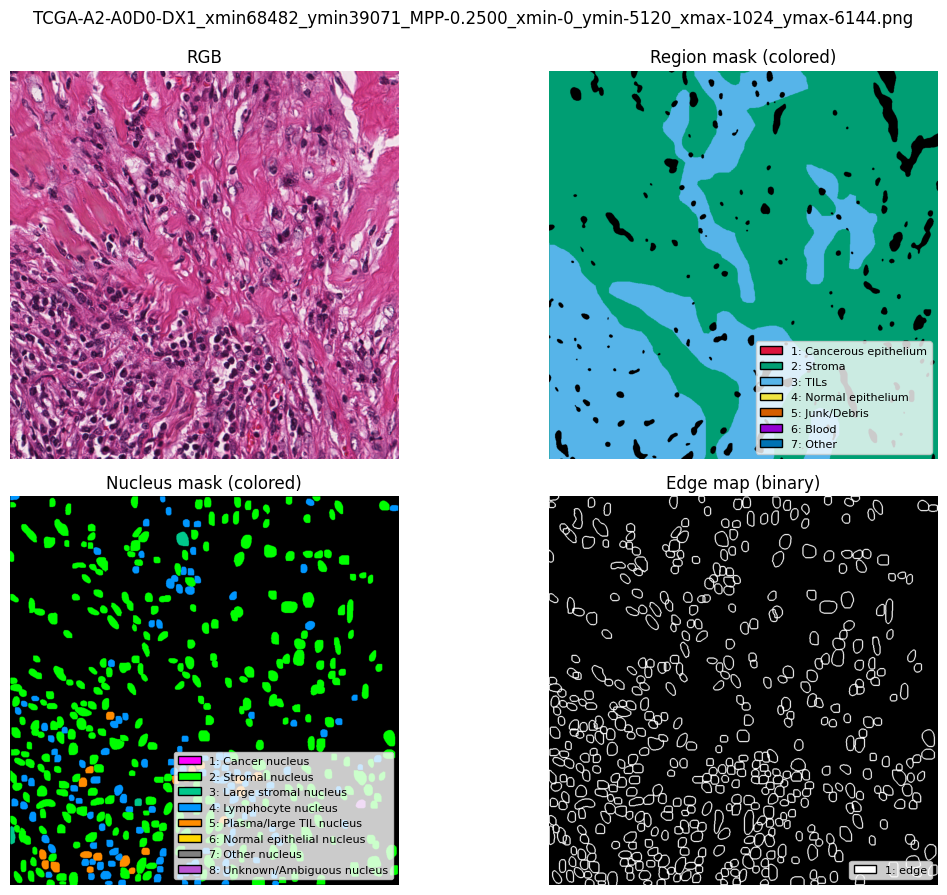

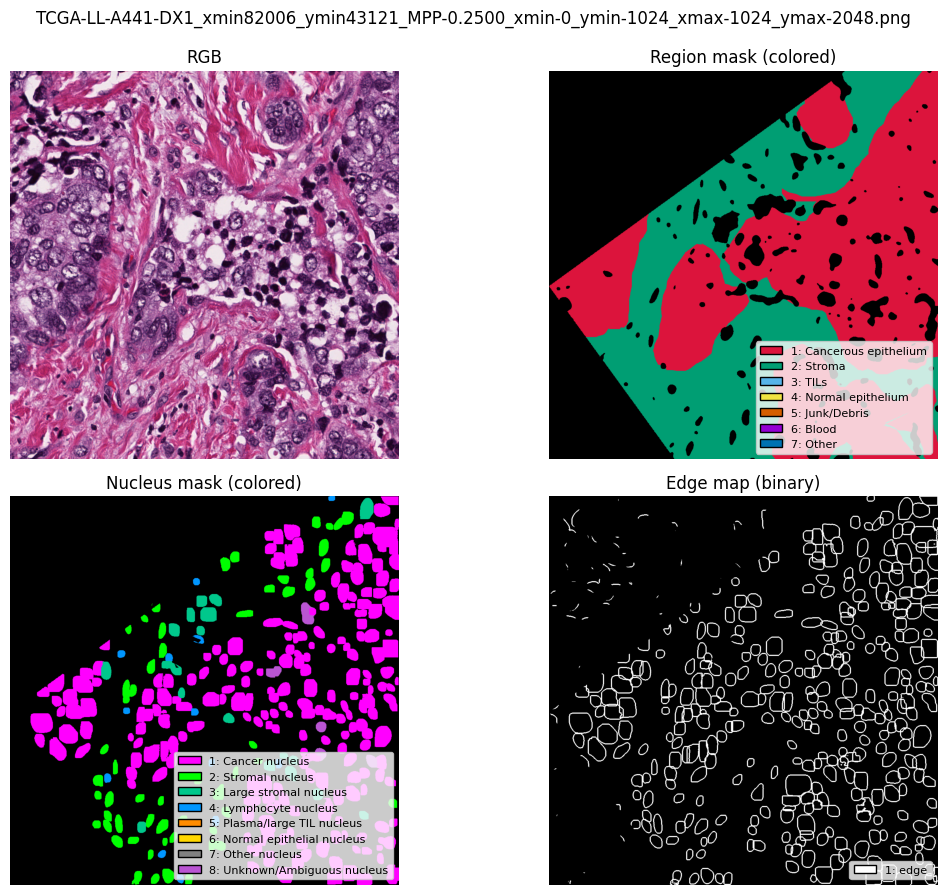

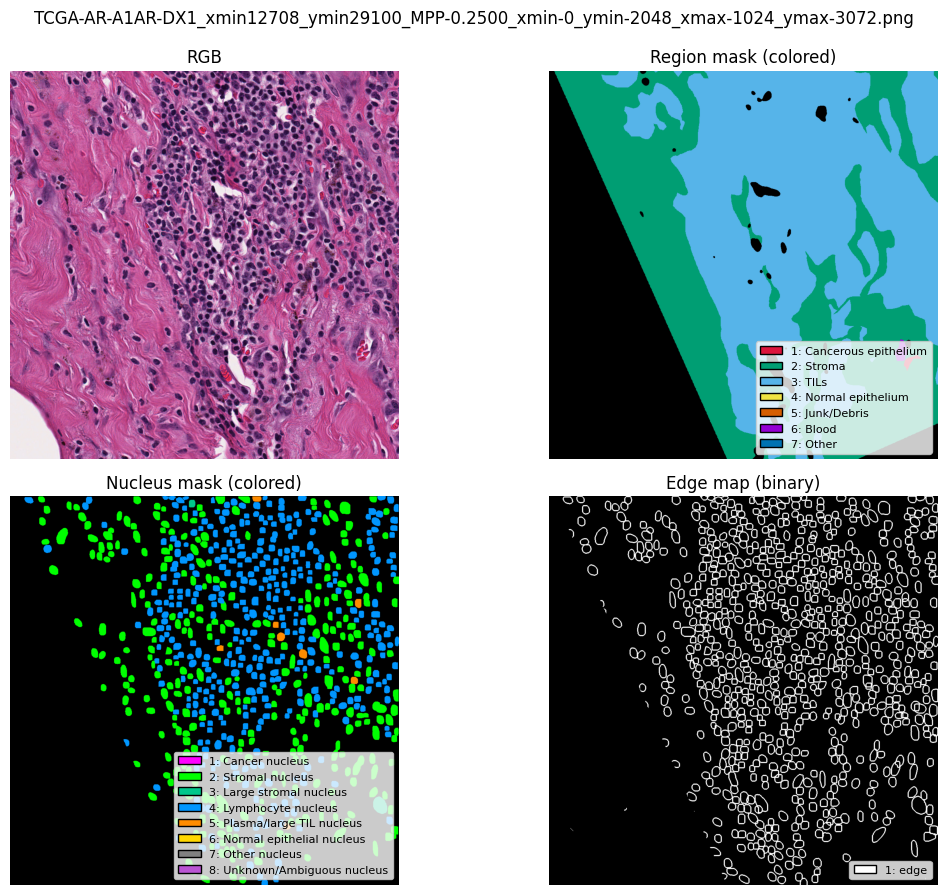

In [1]:
# tcga_eda_full.py

import os
import random
from pathlib import Path
from typing import Dict, Tuple, List

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ----------------------------
# 0) Paths
# ----------------------------
IMAGES_DIR = Path("/home/himanshu/Downloads/tcga-20251015T043235Z-1-002/tcga/rgbs")
MASKS_DIR  = Path("/home/himanshu/Downloads/tcga-20251015T043235Z-1-002/tcga/masks")
IMG_EXTS   = {".png", ".jpg", ".jpeg", ".tif", ".tiff"}
MASK_EXTS  = {".png"}

# ----------------------------
# 1) Class dictionaries (from your screenshot)
# ----------------------------

# First channel (regions)
REGION_LABELS: Dict[int, str] = {
	0: "Exclude",
	1: "Cancerous epithelium",
	2: "Stroma",
	3: "TILs",
	4: "Normal epithelium",
	5: "Junk/Debris",
	6: "Blood",
	7: "Other",
	8: "Whitespace/Empty",
}

# Second channel (nuclei)  NOTE: 9 is the background (non-nuclear material)
NUCLEUS_LABELS: Dict[int, str] = {
	0: "Exclude",
	1: "Cancer nucleus",
	2: "Stromal nucleus",
	3: "Large stromal nucleus",
	4: "Lymphocyte nucleus",
	5: "Plasma/large TIL nucleus",
	6: "Normal epithelial nucleus",
	7: "Other nucleus",
	8: "Unknown/Ambiguous nucleus",
	9: "Background (non-nuclear material)",
}

EDGE_LABELS: Dict[int, str] = {0: "non-edge", 1: "edge"}

# ----------------------------
# 2) Color dictionaries (RGB 0-255)
#    - “transparent_in_overlay” classes are composited with alpha=0
#    - choose distinct, colorblind-friendly hues
# ----------------------------

# Regions
REGION_COLORS: Dict[int, Tuple[int, int, int]] = {
	0: (0, 0, 0),           # Exclude (transparent in overlay)
	1: (220, 20, 60),       # Cancerous epithelium -> crimson
	2: (0, 158, 115),       # Stroma -> green
	3: (86, 180, 233),      # TILs -> sky blue
	4: (240, 228, 66),      # Normal epithelium -> yellow
	5: (213, 94, 0),        # Junk/Debris -> burnt orange
	6: (148, 0, 211),       # Blood -> violet
	7: (0, 114, 178),       # Other -> blue
	8: (0, 0, 0),           # Whitespace/Empty (transparent in overlay)
}
REGION_TRANSPARENT = {0, 8}  # treat as transparent over RGB

# Nuclei
NUCLEUS_COLORS: Dict[int, Tuple[int, int, int]] = {
	0: (0, 0, 0),           # Exclude (transparent)
	1: (255, 0, 255),       # Cancer nucleus -> magenta
	2: (0, 255, 0),         # Stromal nucleus -> green
	3: (0, 200, 140),       # Large stromal nucleus -> teal
	4: (0, 150, 255),       # Lymphocyte nucleus -> light blue
	5: (255, 140, 0),       # Plasma / large TIL -> orange
	6: (255, 215, 0),       # Normal epithelial nucleus -> gold
	7: (128, 128, 128),     # Other nucleus -> gray
	8: (186, 85, 211),      # Unknown/Ambiguous -> medium orchid
	9: (0, 0, 0),           # Background (non-nuclear material) transparent
}
NUCLEUS_TRANSPARENT = {0, 9}

# Edges (binary)
EDGE_COLORS: Dict[int, Tuple[int, int, int]] = {
	0: (0, 0, 0),       # non-edge (transparent)
	1: (255, 255, 255)  # edge -> white (high contrast)
}
EDGE_TRANSPARENT = {0}

# Overlay alphas
ALPHA_REGION = 0.40
ALPHA_NUC    = 0.45
ALPHA_EDGE   = 0.90

# ----------------------------
# 3) File pairing
# ----------------------------
def discover_pairs(images_dir: Path, masks_dir: Path):
	imgs = {p.stem: p for p in images_dir.iterdir() if p.suffix.lower() in IMG_EXTS}
	msks = {p.stem: p for p in masks_dir.iterdir()  if p.suffix.lower() in MASK_EXTS}
	keys = sorted(set(imgs) & set(msks))
	return [(imgs[k], msks[k]) for k in keys]

# ----------------------------
# 4) I/O
# ----------------------------
def load_rgb(path: Path) -> np.ndarray:
	return np.array(Image.open(path).convert("RGB"))

def load_mask(path: Path) -> np.ndarray:
	m = np.array(Image.open(path))
	if m.ndim != 3 or m.shape[-1] != 3:
		raise ValueError(f"Mask must be (H,W,3). Got {m.shape} at {path}.")
	if not np.issubdtype(m.dtype, np.integer):
		m = m.astype(np.uint8)
	return m

# ----------------------------
# 5) Coloring & overlay
# ----------------------------
def colorize(mask_2d: np.ndarray, color_map: Dict[int, Tuple[int,int,int]], transparent_vals: set):
	h, w = mask_2d.shape
	rgb  = np.zeros((h, w, 3), dtype=np.uint8)
	for val, color in color_map.items():
		if val in transparent_vals:  # keep 0 (black), we use a separate alpha mask
			continue
		rgb[mask_2d == val] = color
	# alpha mask: 1 where colored, 0 where transparent classes
	alpha = (~np.isin(mask_2d, list(transparent_vals))).astype(np.uint8)
	return rgb, alpha

def overlay(base_rgb: np.ndarray, over_rgb: np.ndarray, over_alpha01: np.ndarray, alpha_scale: float):
	base = base_rgb.astype(np.float32) / 255.0
	over = over_rgb.astype(np.float32) / 255.0
	a    = (over_alpha01.astype(np.float32) * alpha_scale)[..., None]
	out  = base * (1 - a) + over * a
	return (np.clip(out, 0, 1) * 255).astype(np.uint8)

def make_legend(labels: Dict[int,str], colors: Dict[int,Tuple[int,int,int]], skip: set):
	handles = []
	for k in sorted(labels):
		if k in skip: 
			continue
		c = tuple(v/255 for v in colors[k])
		handles.append(Patch(facecolor=c, edgecolor="black", label=f"{k}: {labels[k]}"))
	return handles

# ----------------------------
# 6) Panels, stats, gallery
# ----------------------------
def plot_panels(rgb: np.ndarray, m_region: np.ndarray, m_nuc: np.ndarray, m_edge: np.ndarray, title: str = ""):
	# colorize (same helpers and dicts as before)
	reg_rgb, reg_a = colorize(m_region, REGION_COLORS, REGION_TRANSPARENT)
	nuc_rgb, nuc_a = colorize(m_nuc,    NUCLEUS_COLORS, NUCLEUS_TRANSPARENT)
	edg_rgb, edg_a = colorize(m_edge,   EDGE_COLORS,    EDGE_TRANSPARENT)

	fig, axes = plt.subplots(2, 2, figsize=(12, 9))
	(ax_rgb, ax_reg), (ax_nuc, ax_edge) = axes

	# RGB
	ax_rgb.imshow(rgb); ax_rgb.set_title("RGB"); ax_rgb.axis("off")

	# Region (colored)
	ax_reg.imshow(reg_rgb); ax_reg.set_title("Region mask (colored)"); ax_reg.axis("off")
	ax_reg.legend(
		handles=make_legend(REGION_LABELS, REGION_COLORS, REGION_TRANSPARENT),
		loc="lower right", fontsize=8, frameon=True
	)

	# Nucleus (colored)
	ax_nuc.imshow(nuc_rgb); ax_nuc.set_title("Nucleus mask (colored)"); ax_nuc.axis("off")
	ax_nuc.legend(
		handles=make_legend(NUCLEUS_LABELS, NUCLEUS_COLORS, NUCLEUS_TRANSPARENT),
		loc="lower right", fontsize=8, frameon=True
	)

	# Edges (colored)
	ax_edge.imshow(edg_rgb); ax_edge.set_title("Edge map (binary)"); ax_edge.axis("off")
	ax_edge.legend(
		handles=make_legend(EDGE_LABELS, EDGE_COLORS, EDGE_TRANSPARENT),
		loc="lower right", fontsize=8, frameon=True
	)

	if title:
		fig.suptitle(title, y=0.99)
	fig.tight_layout()
	plt.show()


def count_values(mask_2d: np.ndarray, labels: Dict[int,str]):
	vals, counts = np.unique(mask_2d, return_counts=True)
	out = {int(v): int(c) for v, c in zip(vals, counts)}
	for k in labels: out.setdefault(k, 0)
	return out

def dataset_stats(pairs: List[Tuple[Path, Path]], limit: int = None):
	reg = {k: 0 for k in REGION_LABELS}
	nuc = {k: 0 for k in NUCLEUS_LABELS}
	edg = {k: 0 for k in EDGE_LABELS}
	total_px = 0
	it = pairs if limit is None else pairs[:limit]
	for _, mpath in it:
		m = load_mask(mpath)
		r, n, e = m[...,0], m[...,1], m[...,2]
		total_px += r.size
		rc = count_values(r, REGION_LABELS)
		nc = count_values(n, NUCLEUS_LABELS)
		ec = count_values(e, EDGE_LABELS)
		for k in reg: reg[k] += rc.get(k, 0)
		for k in nuc: nuc[k] += nc.get(k, 0)
		for k in edg: edg[k] += ec.get(k, 0)
	return {"pixels_total": total_px, "region_counts": reg, "nucleus_counts": nuc, "edge_counts": edg}

def print_stats(stats):
	print(f"Total pixels: {stats['pixels_total']:,}")
	def show(name, counts, labels):
		print(f"\n{name}")
		for k in sorted(labels):
			pct = (counts[k] / stats['pixels_total'] * 100) if stats['pixels_total'] else 0.0
			print(f" {k:2d} | {labels[k]:28s} : {counts[k]:12,d}  ({pct:6.2f}%)")
	show("Regions",  stats["region_counts"],  REGION_LABELS)
	show("Nuclei",   stats["nucleus_counts"], NUCLEUS_LABELS)
	show("Edges",    stats["edge_counts"],    EDGE_LABELS)

def show_random_gallery(pairs, n=6, seed=7):
	random.seed(seed)
	subset = random.sample(pairs, k=min(n, len(pairs)))
	for ip, mp in subset:
		rgb = load_rgb(ip)
		m   = load_mask(mp)
		plot_panels(rgb, m[...,0], m[...,1], m[...,2], title=ip.name)

# ----------------------------
# 7) Run
# ----------------------------
if __name__ == "__main__":
	pairs = discover_pairs(IMAGES_DIR, MASKS_DIR)
	print(f"Found {len(pairs)} pairs")
	if pairs:
		rgb = load_rgb(pairs[0][0])
		m   = load_mask(pairs[0][1])
		print("Sample shapes -> RGB:", rgb.shape, "Mask:", m.shape, "dtype:", m.dtype)

		stats = dataset_stats(pairs)
		print_stats(stats)

		show_random_gallery(pairs, n=5, seed=42)


In [ ]:
#!/usr/bin/env python3
import os
from pathlib import Path
from PIL import Image
from typing import List, Tuple, Optional

# ---- CONFIG ----
RGB_DIR = Path("/home/himanshu/Downloads/tcga-20251015T043235Z-1-002/tcga/rgbs")
MASK_DIR = Path("/home/himanshu/Downloads/tcga-20251015T043235Z-1-002/tcga/masks")

OUT_RGB_DIR = Path("/home/himanshu/Downloads/tcga-20251015T043235Z-1-002/tcga/images_512")
OUT_MASK_DIR = Path("/home/himanshu/Downloads/tcga-20251015T043235Z-1-002/tcga/masks_512")

TILE_SIZE = 512  # patch size (square)
# Set to True to pad images/masks to multiples of TILE_SIZE instead of dropping borders.
PAD_TO_MULTIPLE = False
# ---------------

IMG_EXTS = {".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp", ".gif"}


def list_images(folder: Path) -> List[Path]:
    return sorted([p for p in folder.iterdir() if p.is_file() and p.suffix.lower() in IMG_EXTS])


def build_basename_index(files: List[Path]) -> dict:
    """Map basename without extension -> full path (prefer exact basename uniqueness)."""
    idx = {}
    for p in files:
        base = p.stem
        # If multiple with same stem exist, prefer first; warn on collision
        if base in idx:
            print(f"[WARN] Multiple files share the same basename '{base}'. Using '{idx[base].name}', ignoring '{p.name}'.")
            continue
        idx[base] = p
    return idx


def pad_to_multiple(im: Image.Image, multiple: int, fill: int = 0) -> Image.Image:
    w, h = im.size
    new_w = ((w + multiple - 1) // multiple) * multiple
    new_h = ((h + multiple - 1) // multiple) * multiple
    if new_w == w and new_h == h:
        return im
    # Choose background color depending on mode
    if im.mode in ("1", "L", "P"):
        bg = fill  # grayscale / palette
    elif im.mode == "RGBA":
        bg = (fill, fill, fill, 0)
    else:
        bg = (fill, fill, fill)
    canvas = Image.new(im.mode, (new_w, new_h), bg)
    canvas.paste(im, (0, 0))
    return canvas


def tile_boxes(w: int, h: int, tile: int, pad: bool) -> List[Tuple[int, int, int, int]]:
    if pad:
        W = ((w + tile - 1) // tile) * tile
        H = ((h + tile - 1) // tile) * tile
        cols = W // tile
        rows = H // tile
    else:
        cols = w // tile
        rows = h // tile
    boxes = []
    for r in range(rows):
        for c in range(cols):
            left = c * tile
            upper = r * tile
            right = left + tile
            lower = upper + tile
            # For non-padded, ensure we don't go out of bounds
            if not pad and (right > w or lower > h):
                continue
            boxes.append((left, upper, right, lower))
    return boxes


def ensure_dirs(*paths: Path):
    for p in paths:
        p.mkdir(parents=True, exist_ok=True)


def save_patch(img: Image.Image, out_dir: Path, base: str, r: int, c: int, ext: str = ".png"):
    out_path = out_dir / f"{base}_r{r:04d}_c{c:04d}{ext}"
    img.save(out_path)


def main():
    if not RGB_DIR.exists() or not MASK_DIR.exists():
        raise SystemExit(f"[ERROR] Input directories do not exist:\n  RGB_DIR: {RGB_DIR}\n  MASK_DIR: {MASK_DIR}")

    ensure_dirs(OUT_RGB_DIR, OUT_MASK_DIR)

    rgb_files = list_images(RGB_DIR)
    mask_files = list_images(MASK_DIR)
    if not rgb_files:
        raise SystemExit("[ERROR] No RGB images found.")
    if not mask_files:
        raise SystemExit("[ERROR] No mask images found.")

    mask_index = build_basename_index(mask_files)

    total_imgs = 0
    total_patches = 0
    skipped = 0

    for rgb_path in rgb_files:
        base = rgb_path.stem
        mask_path: Optional[Path] = mask_index.get(base)
        if mask_path is None:
            print(f"[WARN] No corresponding mask found for '{rgb_path.name}'. Skipping.")
            skipped += 1
            continue

        try:
            with Image.open(rgb_path) as rgb_im_raw, Image.open(mask_path) as mask_im_raw:
                # Ensure both are loaded (convert from lazy)
                rgb_im = rgb_im_raw.copy()
                mask_im = mask_im_raw.copy()

            if rgb_im.size != mask_im.size:
                # You can uncomment the resize line to force mask to match image,
                # but it's safer to enforce equality to avoid misalignment.
                # mask_im = mask_im.resize(rgb_im.size, resample=Image.NEAREST)
                print(f"[WARN] Size mismatch for '{base}': RGB={rgb_im.size}, MASK={mask_im.size}. Skipping.")
                skipped += 1
                continue

            # Optional padding
            if PAD_TO_MULTIPLE:
                rgb_im = pad_to_multiple(rgb_im, TILE_SIZE, fill=0)
                # For masks, use nearest-neighbor padding background = 0 (assumed background)
                mask_im = pad_to_multiple(mask_im, TILE_SIZE, fill=0)

            w, h = rgb_im.size
            boxes = tile_boxes(w, h, TILE_SIZE, pad=PAD_TO_MULTIPLE)
            if not boxes:
                print(f"[WARN] '{base}' too small for {TILE_SIZE}x{TILE_SIZE} tiles. Skipping.")
                skipped += 1
                continue

            # Decide extension for output (use .png for consistency)
            out_ext = ".png"

            # Compute rows/cols for naming from grid size
            cols = max(1, ((w + (TILE_SIZE - 1)) // TILE_SIZE) if PAD_TO_MULTIPLE else (w // TILE_SIZE))
            # Iterate and save
            patch_count = 0
            for idx, (l, u, r, d) in enumerate(boxes):
                r_idx = u // TILE_SIZE
                c_idx = l // TILE_SIZE

                rgb_tile = rgb_im.crop((l, u, r, d))
                mask_tile = mask_im.crop((l, u, r, d))

                save_patch(rgb_tile, OUT_RGB_DIR, base, r_idx, c_idx, ext=out_ext)
                save_patch(mask_tile, OUT_MASK_DIR, base, r_idx, c_idx, ext=out_ext)
                patch_count += 1

            total_imgs += 1
            total_patches += patch_count
            print(f"[OK] {base}: {patch_count} patches ({TILE_SIZE}x{TILE_SIZE})")

        except Exception as e:
            print(f"[ERROR] Failed on '{rgb_path.name}': {e}")
            skipped += 1

    print("\n--- Summary ---")
    print(f"Processed images : {total_imgs}")
    print(f"Total patches    : {total_patches}")
    print(f"Skipped          : {skipped}")
    print(f"Output (images)  : {OUT_RGB_DIR}")
    print(f"Output (masks)   : {OUT_MASK_DIR}")


if __name__ == "__main__":
    main()


In [ ]:

def otsu_threshold_01(img01: np.ndarray) -> float:
    """
    Otsu threshold for a grayscale image scaled to [0,1].
    Returns a threshold in [0,1].
    """
    hist, bin_edges = np.histogram(img01.ravel(), bins=256, range=(0.0, 1.0))
    hist = hist.astype(np.float64)
    p = hist / (hist.sum() + 1e-12)
    omega = np.cumsum(p)                      # class probabilities
    mu = np.cumsum(p * np.arange(256))
    mu_t = mu[-1]
    denom = (omega * (1.0 - omega) + 1e-12)
    sigma_b2 = (mu_t * omega - mu) ** 2 / denom
    k_star = int(np.nanargmax(sigma_b2))
    thr = (bin_edges[k_star] + bin_edges[k_star+1]) * 0.5
    return float(np.clip(thr, 0.0, 1.0))

def tissue_mask_from_S(rgb: np.ndarray, method: str = "otsu", fixed_thresh: float = 0.2) -> np.ndarray:
    """
    Compute a boolean mask of 'tissue' using the S channel of HSV.
    method: 'otsu' (default) or 'fixed'
    fixed_thresh: used when method='fixed', threshold in [0,1]
    """
    rgb01 = rgb.astype(np.float32) / 255.0
    hsv = rgb_to_hsv(rgb01)  # returns [0,1] for H,S,V
    S = hsv[..., 1]
    if method == "otsu":
        t = otsu_threshold_01(S)
    else:
        t = float(fixed_thresh)
    return S > t  # boolean mask

# ----------------------------
# 8) Core: metric = (exclude over tissue) / (tissue area)
# ----------------------------
def find_and_plot_exclude_over_tissue_div_tissue_area(
    pairs: List[Tuple[Path, Path]],
    pct_threshold: float = 10.0,
    s_method: str = "otsu",     # 'otsu' or 'fixed'
    s_fixed_thresh: float = 0.2,
    save_json: str = "exclude_over_tissue_div_tissue_area_gt10.json",
    verbose: bool = True
):
    """
    For each image/mask pair:
      1) Build tissue mask by thresholding S channel of HSV.
      2) Compute:
           exclude_mask = (REGION==0)
           tissue_px = sum(tissue)
           exclude_over_tissue_px = sum(exclude_mask & tissue)
           pct = 100 * exclude_over_tissue_px / tissue_px   (if tissue_px==0, pct=0)
      3) If pct > pct_threshold, plot the 2×2 panels and record the filename.
    Saves a JSON with details.
    """
    selected = []
    for ipath, mpath in pairs:
        rgb = load_rgb(ipath)
        m   = load_mask(mpath)
        reg = m[..., 0]
        nuc = m[..., 1]
        edg = m[..., 2]

        # Tissue from S-channel
        tissue = tissue_mask_from_S(rgb, method=s_method, fixed_thresh=s_fixed_thresh)
        tissue_px = int(tissue.sum())

        # Exclude (region==0)
        exclude_mask = (reg == 0)
        exclude_over_tissue_px = int((exclude_mask & tissue).sum())

        if tissue_px == 0:
            pct = 0.0
        else:
            pct = 100.0 * exclude_over_tissue_px / tissue_px

        if verbose:
            print(
                f"{ipath.name}: (exclude∩tissue)/tissue = {pct:6.2f}%  "
                f"(tissue_px={tissue_px:,}, exclude∩tissue={exclude_over_tissue_px:,})"
            )

        if pct > pct_threshold and tissue_px > 0:
            plot_panels(rgb, reg, nuc, edg,
                        title=f"{ipath.name} | (exclude∩tissue)/tissue={pct:.2f}%")
            selected.append({
                "filename": ipath.name,
                "exclude_over_tissue_pct_of_tissue_area": round(pct, 4),
                "tissue_px": tissue_px,
                "exclude_over_tissue_px": exclude_over_tissue_px,
            })

    payload = {
        "threshold_pct": pct_threshold,
        "s_method": s_method,
        "s_fixed_thresh": s_fixed_thresh,
        "results": selected,
    }
    with open(save_json, "w") as f:
        json.dump(payload, f, indent=2)
    if verbose:
        print(f"\nSaved {len(selected)} filenames to {save_json}")

# ----------------------------
# 9) Optional: quick gallery utility (unchanged)
# ----------------------------
def show_random_gallery(pairs, n=6, seed=7):
    random.seed(seed)
    subset = random.sample(pairs, k=min(n, len(pairs)))
    for ip, mp in subset:
        rgb = load_rgb(ip)
        m   = load_mask(mp)
        plot_panels(rgb, m[...,0], m[...,1], m[...,2], title=ip.name)

# ----------------------------
# 10) Main
# ----------------------------
if __name__ == "__main__":
    IMAGES_DIR = Path("/home/himanshu/Downloads/tcga-20251015T043235Z-1-002/tcga/images_512")
    MASKS_DIR  = Path("/home/himanshu/Downloads/tcga-20251015T043235Z-1-002/tcga/masks_512")
    pairs = discover_pairs(IMAGES_DIR, MASKS_DIR)
    print(f"Found {len(pairs)} image/mask pairs.")
    if pairs:
        rgb = load_rgb(pairs[0][0])
        m   = load_mask(pairs[0][1])
        print("Sample shapes -> RGB:", rgb.shape, "Mask:", m.shape, "dtype:", m.dtype)

    # Run the selection + plotting + JSON export
    find_and_plot_exclude_over_tissue_div_tissue_area(
        pairs,
        pct_threshold=10.0,      # change if you want
        s_method="otsu",         # or "fixed"
        s_fixed_thresh=0.2,      # used only when s_method="fixed"
        save_json="exclude_over_tissue_div_tissue_area_gt10.json",
        verbose=False
    )

    # Optionally preview a random gallery (unfiltered)
    # show_random_gallery(pairs, n=6, seed=42)
